# Model benchmarking

- Get a baseline for performance of the 3 model on 20/80 splits (20% train)
- This is more than we will ever get when doing AL (max 18% for Mpro) so we hope to beat these models in terms of recall (but not on R2)
- It also is a proof of principle that AL works for these datasets (i.e. that there is a structure to them)

    ### Influence of chiral fingerprints

    - This is something not respected in published work so far, where the SMILES tend to be racemic. However, in real-world use cases chiral centers are very important for potency, and achiral ECFP fingerprints don't respect them.
    - We compare models trained on chiral vs achiral FPs for Tyk2 (achiral ligands) and Mpro (chiral ligands)

In [2]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr
from exs.ale.models import GPModel, ChempropModel
from exs.mtl_bundle.models.chemprop import model_config as chemprop_config
import pandas as pd
import os

wd = os.getcwd()

utils_nb = os.path.join(wd, "0_Utils.ipynb")
%run {utils_nb}

WARNING - featstreet.warnings._showwarnmsg:109 - /home/ubuntu/anaconda3/envs/ale_env2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



In [3]:
tyk2_data = load_dataset("TYK2", "data/Tyk2_dataset.csv", "Smiles", "dG", lambda x: -(x-47.778) / (8.314e-3 * 298.15 * np.log(10)))
usp7_data = load_dataset("USP7", "data/usp.csv", "canonical smi", "IC50", lambda x: -np.log10(x) + 9)
d2r_data = load_dataset("D2R", "data/Dopamine D2 receptor.csv", 'canonical_smiles', 'pKi', lambda x: x)
mpro_data = load_dataset("Mpro", "data/Mpro.csv", 'SMILES', 'pIC50', lambda x: x)

In [18]:
def run_experiment(data, model_instance, DATASET, MODEL, results):
    
    kf = KFold(n_splits=5, shuffle=True, random_state=10)
    
    for test_index, train_index in kf.split(data):
        train, test = data.iloc[train_index], data.iloc[test_index]
        model_instance.fit(train)
        pred_train, pred_test = model_instance.predict(train), model_instance.predict(test)
        
        result_row = compute_metrics(train, test, pred_train, pred_test, DATASET, MODEL)
        results.loc[len(results)] = result_row
        
    return results

def run_experiment_chemprop(data, DATASET, MODEL, results):
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    
    for test_index, train_index in kf.split(data):
        train, test = data.iloc[train_index], data.iloc[test_index]
        model_args = {
                        'model_name': "ale_chemprop",
                        'fit_args': chemprop_config,
                        'save_to_s3': False,
                        'batch_size': 50,
                        'num_epochs': 50,
                        'eval_metric': "r2",
                        'init_lr': 0.001,
                        'max_lr': 0.01,
                        'final_lr': 0.001,
                        'warmup_epochs': 5,
                        'encoder_from_pretrained_path': os.path.join(wd, "pretrained/chemprop_model_mammal.bin"),
                        'freeze_encoder': False,
                        'df_val': train.copy(),
                        'silence': True,
                    }
#         chem_model = ChempropModel(X_col='SMILES', y_col='affinity', **model_args)
    
        model_instance = ChempropModel(X_col='SMILES', y_col='affinity', **model_args)
        model_instance.fit(train)
        pred_train, pred_test = model_instance.predict(train), model_instance.predict(test)
        
        result_row = compute_metrics(train, test, pred_train, pred_test, DATASET, MODEL)
        results.loc[len(results)] = result_row
        
    return results

def compute_metrics(train, test, pred_train, pred_test, DATASET, MODEL):
    spearman_train = spearmanr(train.affinity, pred_train).correlation
    spearman_test = spearmanr(test.affinity, pred_test).correlation

    rmse_train = mean_squared_error(train.affinity, pred_train, squared=False)
    rmse_test = mean_squared_error(test.affinity, pred_test, squared=False)
            
    train["pred"] = pred_train
    test["pred"] = pred_test

    number_top_2p = test[test.top_2p == True].shape[0]
    top_2p_model = test.sort_values(by='pred', ascending=False)[:number_top_2p].index
    test['top_2p_model'] = False
    test.loc[top_2p_model, 'top_2p_model'] = True
    correct_top2p_percentage = test[(test.top_2p & test.top_2p_model)].shape[0] / number_top_2p
           
    number_top_5p = test[test.top_5p == True].shape[0]
    top_5p_model = test.sort_values(by='pred', ascending=False)[:number_top_5p].index
    test['top_5p_model'] = False
    test.loc[top_5p_model, 'top_5p_model'] = True
    correct_top5p_percentage = test[(test.top_5p & test.top_5p_model)].shape[0] / number_top_5p

    result_row = {
        "Dataset": DATASET,
        "Model": MODEL,
        "R2": r2_score(test.affinity, pred_test),
        "Spearman": spearman_test,
        "RMSE": rmse_test,
        "R2_train": r2_score(train.affinity, pred_train),
        "top_2p": correct_top2p_percentage,
        "top_5p": correct_top5p_percentage
    }

    return result_row


In [19]:
datasets = {"TYK2": tyk2_data, "USP7": usp7_data, "Mpro": mpro_data, "D2R": d2r_data}

results = pd.DataFrame(columns=["Dataset", "Model", "R2", "Spearman", "RMSE", "R2_train", "top_2p", "top_5p"])

In [20]:
for DATASET, data in datasets.items():
    # GP Model
#     results = run_experiment(data, GPModel(X_col="fps", y_col="affinity"), DATASET, "GP", results)
    
#     # GP Model with Chiral Featuriser
#     f_chiral = Featuriser(smiles_col="SMILES", presets="MorganChiral4")
#     data["fps_chiral"] = f_chiral.featurise(data)
#     results = run_experiment(data, GPModel(X_col="fps_chiral", y_col="affinity"), DATASET, "GP_Chiral", results)
    
    # Chemprop Model
    
    results = run_experiment_chemprop(data,DATASET,"Chemprop",results)

100%|███████████████████████████████████████████| 16/16 [00:02<00:00,  6.00it/s]


In [ ]:
for DATASET, data in datasets.items():
    # GP Model
    results = run_experiment(data, GPModel(X_col="fps", y_col="affinity"), DATASET, "GP", results)
    
    # GP Model with Chiral Featuriser
    f_chiral = Featuriser(smiles_col="SMILES", presets="MorganChiral4")
    data["fps_chiral"] = f_chiral.featurise(data)
    results = run_experiment(data, GPModel(X_col="fps_chiral", y_col="affinity"), DATASET, "GP_Chiral", results)
    
    # Chemprop Model
    model_args = {
                    'model_name': "ale_chemprop",
                    'fit_args': chemprop_config,
                    'save_to_s3': False,
                    'batch_size': 50,
                    'num_epochs': 50,
                    'eval_metric': "r2",
                    'init_lr': 0.001,
                    'max_lr': 0.01,
                    'final_lr': 0.001,
                    'warmup_epochs': 5,
                    'encoder_from_pretrained_path': os.path.join(wd, "pretrained/chemprop_model_mammal.bin"),
                    'freeze_encoder': False,
                    'df_val': None,
                    'silence': True,
                }

    chem_model = ChempropModel(X_col='SMILES', y_col='affinity', **model_args)
    results = run_experiment(data, chem_model, DATASET, "Chemprop", results)

### Pickle and save the results

In [21]:
# pickle results and save to data/2_results/
results.to_pickle("data/2_results/results_CP_1.pkl")

In [22]:
results

,Dataset,Model,R2,Spearman,RMSE,R2_train,top_2p,top_5p
0,TYK2,Chemprop,0.783301,0.886336,0.633073,0.838883,0.425806,0.558673
1,TYK2,Chemprop,0.798163,0.893281,0.616299,0.834878,0.520958,0.619048
2,TYK2,Chemprop,0.798459,0.896651,0.609945,0.845180,0.512500,0.600998
3,TYK2,Chemprop,0.791151,0.889787,0.621953,0.836251,0.456790,0.601485
4,TYK2,Chemprop,0.766731,0.876221,0.656956,0.823349,0.480769,0.579208
5,USP7,Chemprop,0.702016,0.849879,0.716083,0.838199,0.025641,0.481283
6,USP7,Chemprop,0.698580,0.855202,0.715465,0.842576,0.157143,0.309392
7,USP7,Chemprop,0.699927,0.850819,0.710293,0.816465,0.040541,0.423729
8,USP7,Chemprop,0.705535,0.853200,0.713071,0.809710,0.214286,0.259669
9,USP7,Chemprop,0.700717,0.856541,0.721677,0.811437,0.041667,0.489011


In [38]:
import pandas as pd

data_location = "data/2_results/"

df1 = pd.read_pickle(data_location + 'results_CP_1.pkl')
df2 = pd.read_pickle(data_location + 'results_CP_5.pkl')
df3 = pd.read_pickle(data_location + 'results_CP_10.pkl')
df1['seed'] = 1
df2['seed'] = 2
df3['seed'] = 3
target_df = pd.read_pickle(data_location + 'results_CP_GP_GPC_3seeds.pkl')
combined_df = pd.concat([df1, df2, df3], axis=0)


In [40]:
# Filter rows where 'Model' is 'CP' in target_df
cp_rows = target_df[target_df['Model'] == 'CP']

# Ensure the number of rows matches
if len(cp_rows) == len(combined_df):
    target_df.loc[target_df['Model'] == 'CP'] = combined_df.values
else:
    print("Number of 'CP' rows in target_df does not match the number of rows in combined_df.")


In [41]:
target_df

,Dataset,Model,R2,Spearman,RMSE,R2_train,top_2p,top_5p,seed
0,TYK2,GP,0.748753,0.865234,0.681672,0.956658,0.483871,0.538265,1
1,TYK2,GP,0.755955,0.870391,0.677682,0.953426,0.449102,0.548872,1
2,TYK2,GP,0.759139,0.869500,0.666796,0.960250,0.500000,0.541147,1
3,TYK2,GP,0.746136,0.862721,0.685712,0.951944,0.475309,0.542079,1
4,TYK2,GP,0.757763,0.869374,0.669466,0.951088,0.506410,0.549505,1
...,...,...,...,...,...,...,...,...,...
175,D2R,Chemprop,0.357626,0.376609,1.173306,0.449298,0.051282,0.171429,3
176,D2R,Chemprop,0.302159,0.347240,1.211382,0.476984,0.047619,0.112245,3
177,D2R,Chemprop,0.365177,0.438046,1.122034,0.762346,0.117647,0.197802,3
178,D2R,Chemprop,0.295233,0.476787,1.248132,0.624734,0.184211,0.260000,3


In [47]:
target_df.to_pickle(data_location + 'modified_results_CP_GP_GPC_3seeds_upd.pkl')


In [46]:
target_df['Model'] = target_df['Model'].replace('Chemprop', 'CP')


## Results data and Plots

In [2]:
import pandas as pd

In [3]:
combined_results = pd.read_pickle("data/2_results/combined_results_all.pkl")

In [4]:
results_averaged =combined_results.replace(0, 0.).reset_index()
results_melt = results_averaged.melt(id_vars=["Dataset", "Model"], value_vars=["R2","Spearman","RMSE", "top_2p", "top_5p"])
results_melt

,Dataset,Model,variable,value
0,TYK2,GP,R2,0.750646
1,TYK2,GP,R2,0.748231
2,TYK2,GP,R2,0.757509
3,TYK2,GP,R2,0.751606
4,TYK2,GP,R2,0.750326
...,...,...,...,...
295,TYK2,CP,top_5p,0.626866
296,TYK2,CP,top_5p,0.598997
297,TYK2,CP,top_5p,0.617128
298,TYK2,CP,top_5p,0.628362


In [6]:
combined_results[combined_results['Dataset']=='TYK2']

,Dataset,Model,R2,Spearman,RMSE,R2_train,top_2p,top_5p
0,TYK2,GP,0.750646,0.865940,0.679201,0.956773,0.467532,0.549751
1,TYK2,GP,0.748231,0.867515,0.683249,0.962267,0.406250,0.513784
2,TYK2,GP,0.757509,0.870442,0.668730,0.956706,0.469512,0.536524
3,TYK2,GP,0.751606,0.866263,0.681029,0.947386,0.481250,0.547677
4,TYK2,GP,0.750326,0.864653,0.682192,0.952182,0.493827,0.531807
5,TYK2,GP_Chiral,0.817104,0.903539,0.581691,0.978456,0.584416,0.626866
6,TYK2,GP_Chiral,0.808713,0.902843,0.595553,0.977342,0.475000,0.601504
7,TYK2,GP_Chiral,0.820210,0.904768,0.575819,0.976621,0.542683,0.612091
8,TYK2,GP_Chiral,0.809641,0.899179,0.596187,0.974687,0.568750,0.647922
9,TYK2,GP_Chiral,0.810104,0.899477,0.594947,0.990492,0.567901,0.641221


In [5]:
results_melt[results_melt['Dataset']=='TYK2']

,Dataset,Model,variable,value
0,TYK2,GP,R2,0.750646
1,TYK2,GP,R2,0.748231
2,TYK2,GP,R2,0.757509
3,TYK2,GP,R2,0.751606
4,TYK2,GP,R2,0.750326
...,...,...,...,...
295,TYK2,CP,top_5p,0.626866
296,TYK2,CP,top_5p,0.598997
297,TYK2,CP,top_5p,0.617128
298,TYK2,CP,top_5p,0.628362


In [24]:
pd.set_option('display.max_rows', None)  # None means unlimited rows
pd.set_option('display.max_columns', None)  # None means unlimited columns
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

In [25]:
results_melt

,Dataset,Model,variable,value
0,TYK2,GP,R2,0.750646
1,TYK2,GP,R2,0.748231
2,TYK2,GP,R2,0.757509
3,TYK2,GP,R2,0.751606
4,TYK2,GP,R2,0.750326
5,TYK2,GP_Chiral,R2,0.817104
6,TYK2,GP_Chiral,R2,0.808713
7,TYK2,GP_Chiral,R2,0.820210
8,TYK2,GP_Chiral,R2,0.809641
9,TYK2,GP_Chiral,R2,0.810104


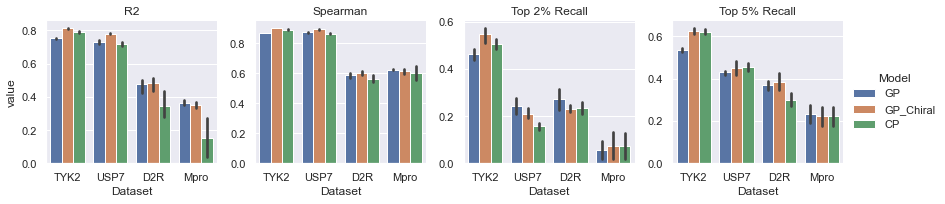

In [13]:
import seaborn as sns
sns.set()

results_for_plot = results_melt[results_melt.variable != "RMSE"]
results_for_plot.loc[results_for_plot.variable == "top_2p", "variable"] = "Top 2% Recall"
results_for_plot.loc[results_for_plot.variable == "top_5p", "variable"] = "Top 5% Recall"
g = sns.catplot(data=results_for_plot, x="Dataset", y="value", col="variable", hue="Model", kind="bar", sharey=False, errorbar=("ci", 95), \
    order=DATASET_ORDER, hue_order=["GP", "GP_Chiral", "CP"], height=3)
g.set_titles(template='{col_name}')

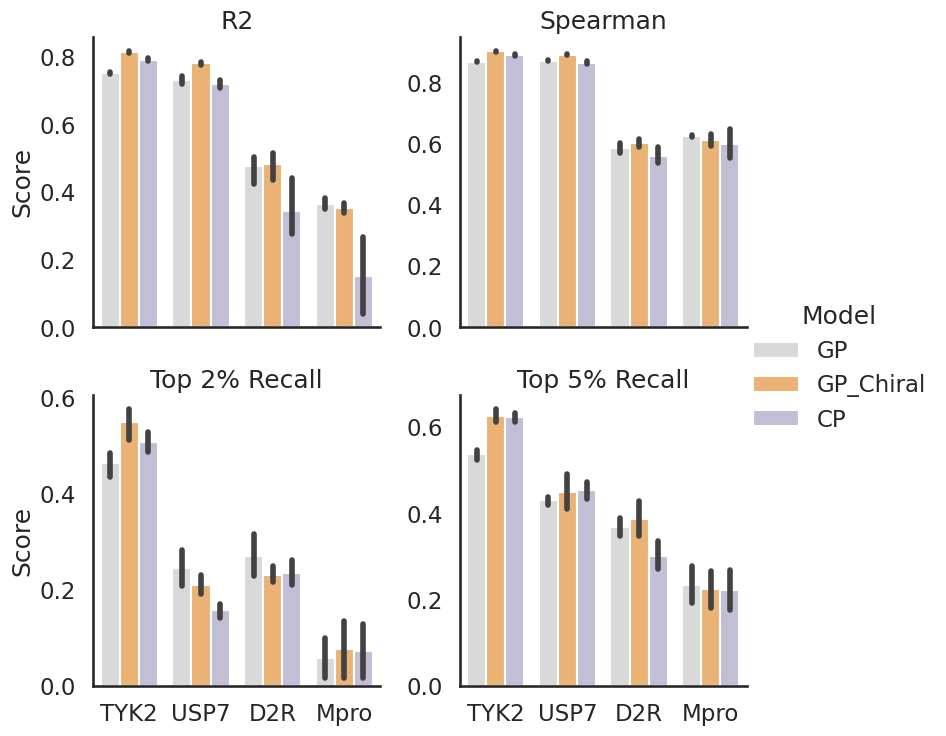

In [82]:
import seaborn as sns


sns.set_style("white")
sns.set_context("talk") 
color_palette = sns.color_palette("Set3_r", 3) 

results_for_plot = results_melt[results_melt.variable != "RMSE"]
results_for_plot.loc[results_for_plot.variable == "top_2p", "variable"] = "Top 2% Recall"
results_for_plot.loc[results_for_plot.variable == "top_5p", "variable"] = "Top 5% Recall"

g = sns.catplot(data=results_for_plot, x="Dataset", y="value", col="variable", hue="Model", kind="bar", sharey=False, 
                errorbar=("ci", 95), order=DATASET_ORDER, hue_order=["GP", "GP_Chiral", "CP"], height=4, aspect=1, 
                palette=color_palette, col_wrap=2)
g.set_titles(template='{col_name}')
g.set_axis_labels("", "Score") 
sns.despine()  


In [21]:
font_sizes = {
    "axes.labelsize": 15,   # Axis labels
    "axes.titlesize": 16,   # Title
    "xtick.labelsize": 15,  # X-axis tick labels
    "ytick.labelsize": 16,  # Y-axis tick labels
    "legend.fontsize": 14,  # Legend
    "font.size": 14         # General font size
}



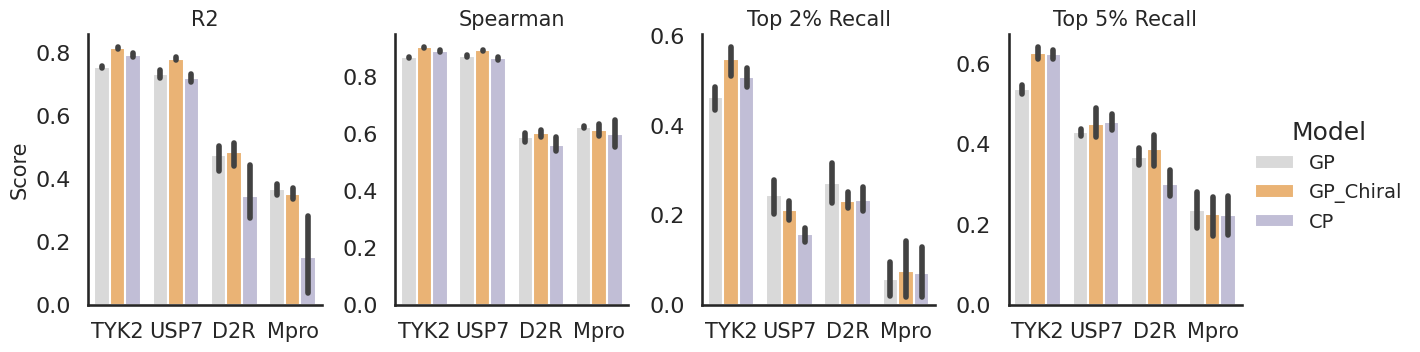

In [22]:
import seaborn as sns

sns.set_style("white")
sns.set_context("talk", rc=font_sizes)
color_palette = sns.color_palette("Set3_r", 3)

results_for_plot = results_melt[results_melt.variable != "RMSE"]
results_for_plot.loc[results_for_plot.variable == "top_2p", "variable"] = "Top 2% Recall"
results_for_plot.loc[results_for_plot.variable == "top_5p", "variable"] = "Top 5% Recall"

g = sns.catplot(data=results_for_plot, x="Dataset", y="value", col="variable", hue="Model", kind="bar", sharey=False,
                errorbar=("ci", 95), order=DATASET_ORDER, hue_order=["GP", "GP_Chiral", "CP"], height=4, aspect=0.8,
                palette=color_palette)
g.set_titles(template='{col_name}')
g.set_axis_labels("", "Score")
sns.despine()


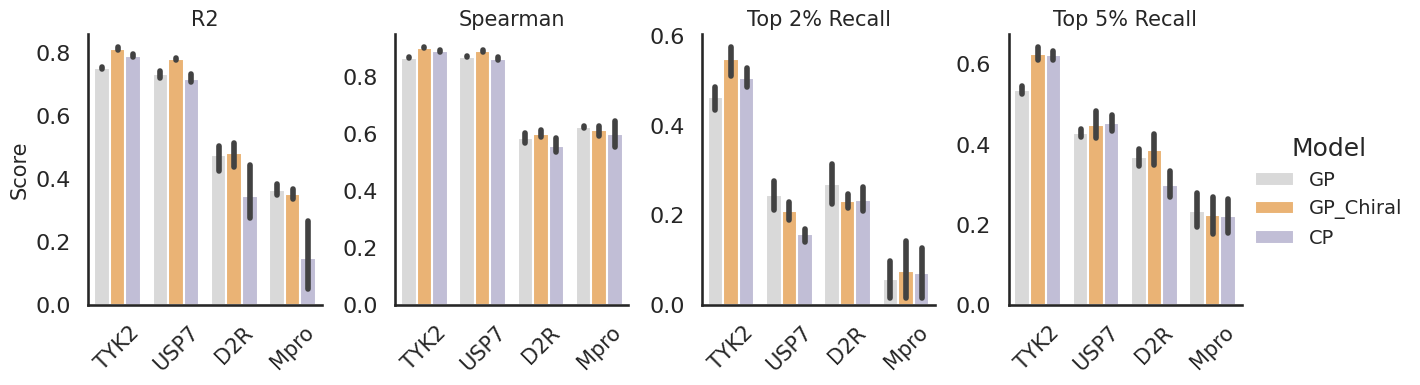

In [46]:
import seaborn as sns

sns.set_style("white")
sns.set_context("talk", rc=font_sizes)
color_palette = sns.color_palette("Set3_r", 3)

results_for_plot = results_melt[results_melt.variable != "RMSE"]
results_for_plot.loc[results_for_plot.variable == "top_2p", "variable"] = "Top 2% Recall"
results_for_plot.loc[results_for_plot.variable == "top_5p", "variable"] = "Top 5% Recall"

g = sns.catplot(data=results_for_plot, x="Dataset", y="value", col="variable", hue="Model", kind="bar", sharey=False,
                errorbar=("ci", 95), order=DATASET_ORDER, hue_order=["GP", "GP_Chiral", "CP"], height=4, aspect=0.8,
                palette=color_palette)
g.set_titles(template='{col_name}')
g.set_axis_labels("", "Score")
g.set_xticklabels(rotation=45)
# g.set_yticklabels()
sns.despine()


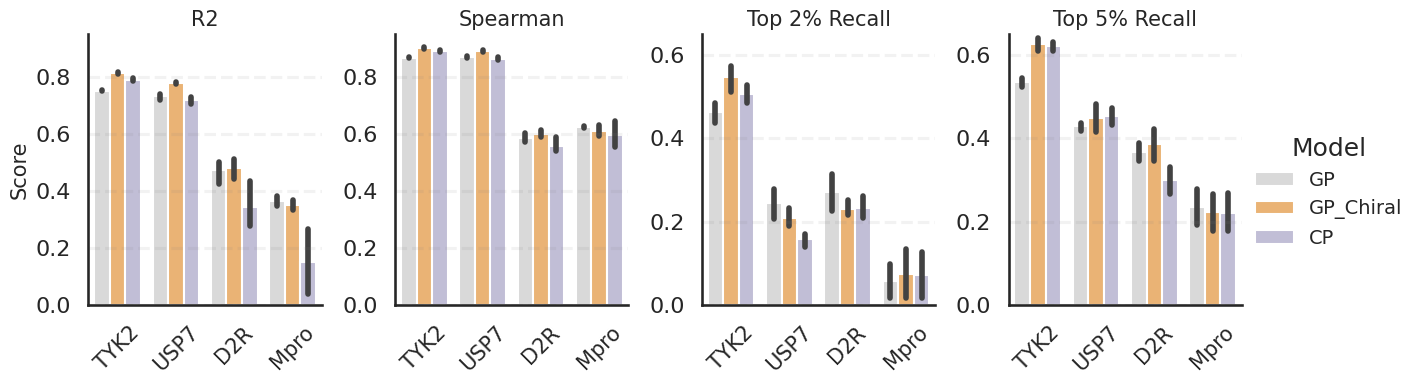

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("white")
sns.set_context("talk", rc=font_sizes)
color_palette = sns.color_palette("Set3_r", 3)

results_for_plot = results_melt[results_melt.variable != "RMSE"]
results_for_plot.loc[results_for_plot.variable == "top_2p", "variable"] = "Top 2% Recall"
results_for_plot.loc[results_for_plot.variable == "top_5p", "variable"] = "Top 5% Recall"

g = sns.catplot(data=results_for_plot, x="Dataset", y="value", col="variable", hue="Model", kind="bar", sharey=False,
                errorbar=("ci", 95), order=DATASET_ORDER, hue_order=["GP", "GP_Chiral", "CP"], height=4, aspect=0.8,
                palette=color_palette)

# Set consistent y-axis scales
g.axes[0][0].set_ylim(0, 0.95)

g.axes[0][1].set_ylim(0, 0.95)  

g.axes[0][2].set_ylim(0, 0.65)

g.axes[0][3].set_ylim(0, 0.65)


# Add x-axis and y-axis tick labels
g.set_xticklabels(rotation=45)
# g.set_yticklabels()
# Set y-ticks for each subplot
# for i,ax in enumerate(g.axes.flat):
#     if i==0 or 1:
#         ax.set_yticks([0.2,0.4,0.6,0.8,1])
#     else:
#         ax.set_yticks([0,0.2,0.4,0.6])
for ax in g.axes.flat:
    for y in [0,0.2,0.4,0.6,0.8]:
        ax.axhline(y, color='gray', linestyle='dashed', alpha=0.1)
g.set_titles(template='{col_name}')
g.set_axis_labels("", "Score")
sns.despine()

plt.show()


## Obsolete

/tmp/ipykernel_2048/983386023.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(data=results_plot, x="Dataset", y="mean", col="variable", hue="Model", kind="bar", sharey=False, ci=None)


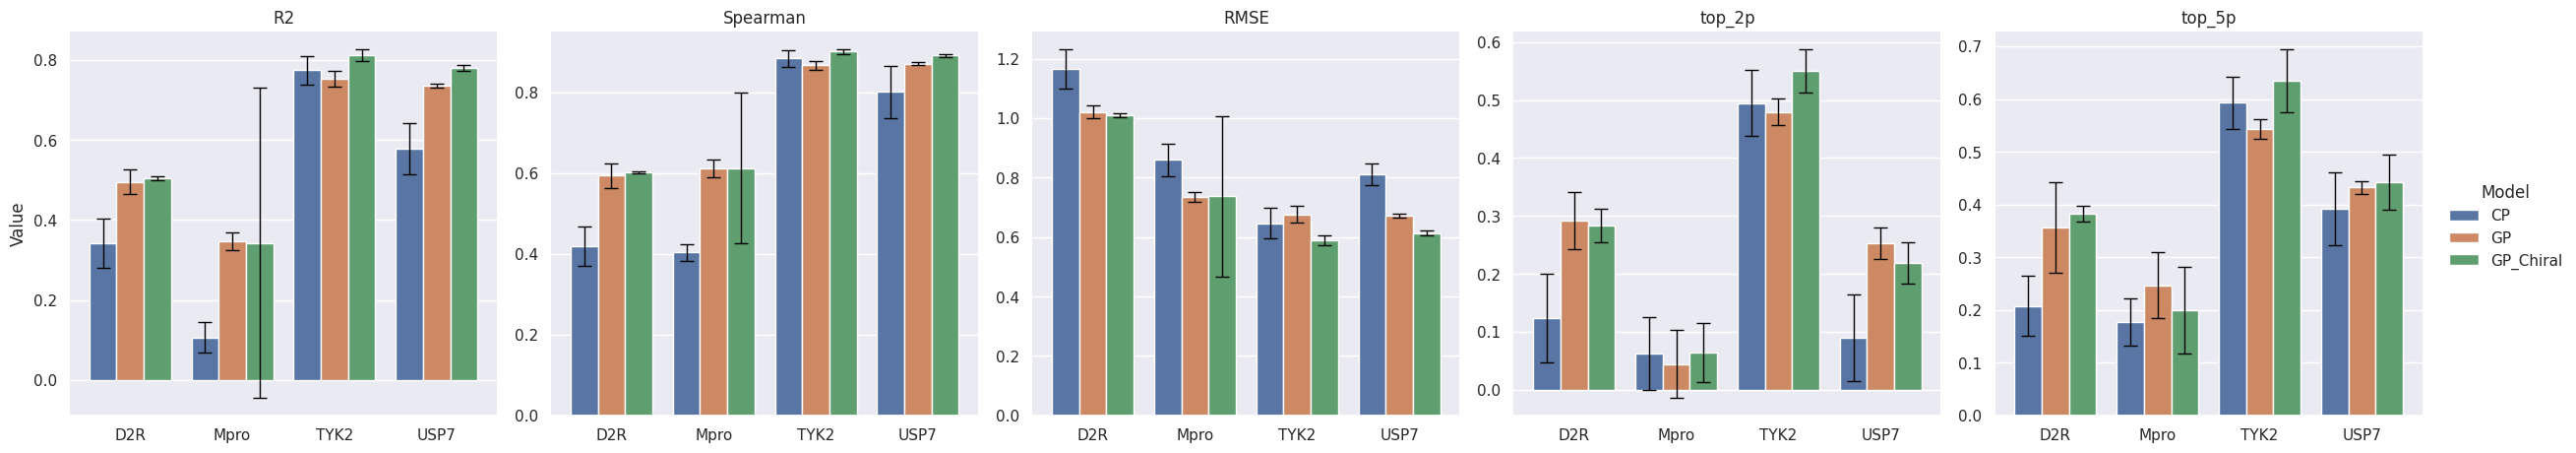

In [16]:
import pandas as pd
import seaborn as sns

# Calculate the mean and standard error
results_mean = combined_results.replace(0, 0.).groupby(["Dataset", "Model"]).mean().reset_index()
results_std = combined_results.replace(0, 0.).groupby(["Dataset", "Model"]).std().reset_index()

# Merge results_mean and results_std for plotting
results_mean_melt = results_mean.melt(id_vars=["Dataset", "Model"], value_vars=["R2", "Spearman", "RMSE", "top_2p", "top_5p"], var_name="variable", value_name="mean")
results_std_melt = results_std.melt(id_vars=["Dataset", "Model"], value_vars=["R2", "Spearman", "RMSE", "top_2p", "top_5p"], var_name="variable", value_name="error")

results_plot = pd.merge(results_mean_melt, results_std_melt, on=["Dataset", "Model", "variable"])

# Pivot the data for easier extraction of errors
error_df = results_plot.pivot_table(index=["Dataset", "variable", "Model"], values="error").unstack().reset_index()
error_values = error_df.values[:, 2:]



# Plot the barplot without error bars
g = sns.catplot(data=results_plot, x="Dataset", y="mean", col="variable", hue="Model", kind="bar", sharey=False, ci=None)
g.set_axis_labels("", "Value").set_titles("{col_name}").despine(left=True)

# Add error bars
for ax, variable in zip(g.axes.flat, ["R2", "Spearman", "RMSE", "top_2p", "top_5p"]):
    sub_df = results_plot[results_plot["variable"] == variable]
    for i, (index, row) in enumerate(sub_df.iterrows()):
        # The position and height of the bar can be extracted from the patches of the current axis
        bar = ax.patches[i]
        x = bar.get_x() + bar.get_width() / 2.
        h = bar.get_height()
        # Extract the error value from our results_plot dataframe
        error = row["error"]
        # Draw the error bar
        ax.errorbar(x, h, yerr=error, color='black', capsize=5, elinewidth=1, ls='none')

